## INITIALIZATION

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from bitarray import bitarray
from tjmonopix.tjmonopix import TJMonoPix
%matplotlib notebook

from tjmonopix.online_monitor import noise_monitor, plots
from tjmonopix.analysis import analysis_functions

In [2]:
##### if HV is on, no_power_reset=True,
##### if GPAC had power reset then no_power_reset=False

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml",no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45

2022-03-01 10:06:59,661 [INFO ] (MainThread) GPAC: power reset
2022-03-01 10:07:01,411 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-03-01 10:07:01,641 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-03-01 10:07:01,880 [INFO ] (MainThread) ibias = 45
2022-03-01 10:07:01,894 [INFO ] (MainThread) ibias = 503.125 nA
2022-03-01 10:07:02,480 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 49.64478938256647, 'VDDD [V]': 1.8005150383838384, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0562788421426692, 'VDDD OC': False, 'VPC [mA]': -0.07199967751338733, 'VPCSWSF [mA]': -0.1230610563724649, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [3]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
power_status = chip.get_power_status(printen=True)

BiasSF [V] = 1.05927951037
BiasSF [mA] = 0.101098923188
VDDA OC = False
VDDA [V] = 1.80585654955
VDDA [mA] = 50.1513688658
VDDA_DAC OC = False
VDDA_DAC [V] = 1.80454723776
VDDA_DAC [mA] = 2.50247174749
VDDD OC = False
VDDD [V] = 1.80151403636
VDDD [mA] = 2.82028899904e-08
VDDP OC = False
VDDP [V] = 1.80597981426
VDDP [mA] = 128.397148053
VPC [V] = 1.29985064635
VPC [mA] = -0.445998029929
VPCSWSF [V] = 0.50015423958
VPCSWSF [mA] = 0.0410203601488


## COLUMN SETTINGS: FLAVOURS, MASKS, INJECTION

In [4]:
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW

chip.write_conf()

In [5]:
# SELECT WHICH PHYSICAL COLUMNS, ROWS, DIAGONALS TO MASK
# TO MASK ONE PIXEL, MASKV, MASKH and MASKD OF THIS PIXEL SHOULD BE 0 (FALSE)
# THE MASKD NUMBER OF THE PIXEL WE WANT TO MASK (or UNMASK), IS GIVEN BY: MASKD = PHYSCOL- PHYSROW
# IF PHYSCOL-PHYSROW<0, then MASKD = 448+PHYSCOL-PHYSROW
chip['CONF_SR']['MASKD'].setall(True)
chip['CONF_SR']['MASKH'].setall(True)
chip['CONF_SR']['MASKV'].setall(True)

# TO USE THE MASK FUNCTION YOU MUST INPUT THE FLAVOR, COLUMN AND ROW
# THE FLAVOR NUMERS IS: 0 FOR PMOS_NOSF, 1 FOR PMOS, 2 FOR COMP, 3 FOR HV

chip.write_conf()

In [6]:
# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)

chip.write_conf()

In [7]:
# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()

## ANALOG FRONT END CONFIGURATION

In [8]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator
ibias_dac = 100


## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# Cinj=230aF => 1.43e-/mV
# VDAC LSB=14.17mV => 20.3e-/LSB
# The default values are VL=44, VH=79, VH-VL=35 => ~710e-
CALCAP=33 ## 33 or 14.17E-3*230E-18/1.602E-19=20.3
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

2022-03-01 10:07:30,319 [INFO ] (MainThread) vl = 0.951929133858V
2022-03-01 10:07:30,388 [INFO ] (MainThread) vh = 1.51885826772V


In [9]:
# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-03-01 10:07:33,424 [INFO ] (MainThread) vreset = 1.05106299213V
2022-03-01 10:07:33,440 [INFO ] (MainThread) icasn = 0
2022-03-01 10:07:33,454 [INFO ] (MainThread) icasn = 4.375 nA
2022-03-01 10:07:33,461 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-03-01 10:07:33,493 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-03-01 10:07:33,509 [INFO ] (MainThread) ithr = 5
2022-03-01 10:07:33,523 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-03-01 10:07:33,539 [INFO ] (MainThread) idb = 50
2022-03-01 10:07:33,555 [INFO ] (MainThread) idb = 892.5 nA
2022-03-01 10:07:33,576 [INFO ] (MainThread) ibias = 100
2022-03-01 10:07:33,592 [INFO ] (MainThread) ibias = 1104.6875 nA


For using external ICASN instead:
```python
chip['DACMON_ICASN'].set_current(0, unit='uA')
chip['CONF_SR']['SWCNTL_ICASN']=True
chip.write_conf()
time.sleep(1)
print chip['DACMON_ICASN'].get_voltage()
print chip['DACMON_ICASN'].get_current()
```

## ENABLE MASK

Got 229349 hits in 0.2 s


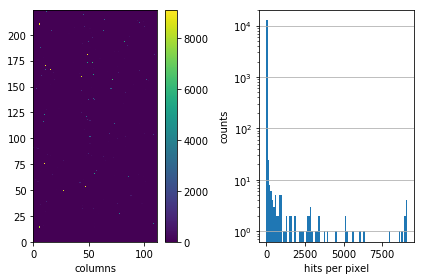

In [10]:
chip.unmask_all()
plots.tj_plot(chip);

Enable MASKH 50
Got 53776 hits, total noisy pixels: 29
Enable MASKH 100
Got 105485 hits, total noisy pixels: 84
Enable MASKH 150
Got 24090 hits, total noisy pixels: 128
Enable MASKH 200
Got 167684 hits, total noisy pixels: 212
Enable MASKH 223
Got 44322 hits, total noisy pixels: 248
Enable MASKV 50
Got 123 hits, total noisy pixels: 250
Enable MASKV 100
Got 10 hits, total noisy pixels: 251
Enable MASKV 111
Got 82 hits, total noisy pixels: 252
Enable MASKD 50
Got 10 hits, total noisy pixels: 253
Enable MASKD 100
Got 6 hits, total noisy pixels: 253
Enable MASKD 150
Got 5 hits, total noisy pixels: 255
Enable MASKD 200
Got 42 hits, total noisy pixels: 257
Enable MASKD 250
Got 124 hits, total noisy pixels: 259
Enable MASKD 300
Got 121 hits, total noisy pixels: 259
Enable MASKD 350
Got 30 hits, total noisy pixels: 262
Enable MASKD 400
Got 109 hits, total noisy pixels: 266
Enable MASKD 447
Got 18 hits, total noisy pixels: 270
Checking again after masking
Got 16 hits, total noisy pixels: 272
No

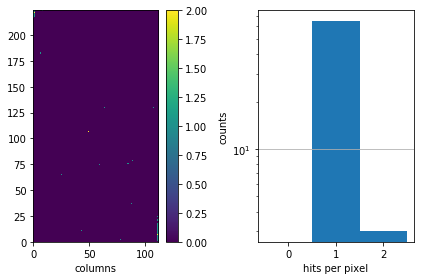

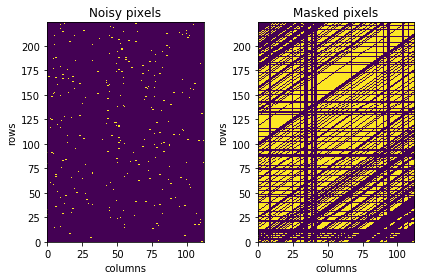

Exception in thread TcpReadoutThread:
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\ProgramData\Miniconda2\lib\threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "c:\users\belle2\basil\basil\TL\SiTcp.py", line 406, in _tcp_readout
    data = bytearray(self._sock_tcp.recv(1024 * 8))
error: [Errno 10054] Connessione in corso interrotta forzatamente dall'host remoto



In [12]:
""" Software parameters to select: 
    the threshold above whitch a pixel is defined noisy (th = number of hits per pixel), 
    the step (),
    the time of the data acquisition run (in s) """
th = 2
step = 50
dt = 0.2

# Auto-mask and plot again
noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
plots.tj_plot(chip);

plt.figure()
plt.subplot(1, 2, 1)
plt.hist2d([x[1] for x in noisy_pixels], [x[2] for x in noisy_pixels], bins=[112,224], range=[[0,112],[0,224]])
plt.title("Noisy pixels")
plt.xlabel('columns')
plt.ylabel('rows')

plt.subplot(1, 2, 2)
plt.hist2d([x[0] for x in mask], [x[1] for x in mask], bins=[112,224], range=[[0,112],[0,224]])
plt.title("Masked pixels")
plt.xlabel('columns')
plt.ylabel('rows')

plt.tight_layout()
plt.show()

## OCCUPANCY

In [ ]:
pix_tmp, cnt = chip.get_occupancy(dt);

In [ ]:
#save some outout monitor files
date_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

output_file_power_status = date_string + 'power_status.txt'
output_file_parameters = 'parameters.txt'
output_file_noisy_pixels = date_string + '_noisy_pixels.txt'
output_file_hits_per_pixels = date_string + '_hits_pixels.txt'

noise_monitor.save_noisy_pixels(np.array(list(noisy_pixels)), output_file_noisy_pixels)
noise_monitor.save_param_and_noise(
    setted_param_dac, setted_param, len(noisy_pixels), n_disabled_pixels, output_file_parameters)
noise_monitor.save_power_status(power_status, output_file_power_status)

#noise_monitor.save_hits_per_pixels(hits, pixels, hits_per_pixel, output_file_hits_per_pixels)

# ENABLE INJECTION

In [ ]:
col_to_inject = 90
row_to_inject = 55

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
#chip.enable_injection(3, col_to_inject, row_to_inject)
chip.write_conf()

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)


## INJECTION SCANS 

In [ ]:
injlist = np.arange(80, 0, -1)
inj_low_dac = self.get_vl_dacunits()

cnt, tot, inj_high = chip.injection_scan(injlist, inj_low_dac, col_to_inject, row_to_inject)


# S-CURVE

In [ ]:
analysis_functions.find_approx_threshold(injlist, inj_high, cnt, repeat, CALCAP)
plots.s_curve(injlist, cnt, tot, CALCAP);